# Mangrove Analysis  

## Global Mangrove Watch Data
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. It uses combined ALOS PALSAR and Landsat (optical) data to form a baseline shapefile for the year 2010. More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). To summarize, GMW shapefiles provide a general location of all mangroves in the world.

The shapefile used by this notebook is a country specific extraction from the global shapefile provided by GMW. The purpose of this notebook is to use the extracted shapefile as a baseline for classifying mangroves through NDVI thresholding. We then analyze how the mangroves change over time in our area of interest.

---
## Analysis Process
The process begins with retrieving data for a specific area in a time series. This dataset is then compressed into a mean composite for each year. From the mean composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

![mangrove_decision_tree.png](mangrove_decision_tree.png)


After classification, we can perform a variety of analyses on the data. We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Define Options Here
Areas and times of interest are included as examples.

In [1]:
PLATFORM = 'LANDSAT_7'
PRODUCT = 'ls7_ledaps_kenya'

# Mombasa, Kenya
LATITUDE = (-4.1, -3.9) 
LONGITUDE = (39.5, 39.7) 
YEARS = (2010, 2016)

SHAPEFILE = 'mangroves/kenya/kenya_man.shp'

NDVI_THRESHOLD = 0.4

## Imports

In [2]:
%matplotlib inline

from sys import path
path.append("../")

import datacube
import fiona
import functools as ft
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import seaborn as sns
import xarray as xr

import geopandas as gpd
from datacube.utils import geometry

from matplotlib.ticker import MaxNLocator
from shapely.geometry import shape

from odc.ui import with_ui_cbk
from odc.algo import to_f32, from_float, xr_geomedian
# from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
# from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa
# from utils.data_cube_utilities.dc_mosaic import ls7_unpack_qa
# from utils.data_cube_utilities.dc_mosaic import ls5_unpack_qa
# from utils.data_cube_utilities.dc_rgb import rgb
import sys
sys.path.append('../Scripts')

import warnings
warnings.filterwarnings("ignore")

from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

## Load the Data
This method loads the data from the Open Datacube using the defined options above.

## Mean Mosaic
This object will create the mean temporal composite for each year in the dataset.

In [4]:
class TemporalCompositor:
    """A TemporalCompositor object for creating mean composites over a temporal dimension.
    
    Attributes:
        dataset (xarray.Dataset): The dataset used in the compositing.
    """
    __slots__ = ('dataset', 'platform')
    
    def __init__(self, dataset, platform):
        """Initialize object and set the dataset.
        
        Args:
            dataset (xarray.Dataset): The dataset used in the compositing.
        """
        self.dataset = dataset
        self.platform = platform
        
    def clean_mask(self, func):
        """A function to create a clean mask for compositing.
        
        Args:
            func (function): The function used for unpacking pixel_qa.
        
        Returns:
            The clean mask.
        """
        water_mask = func(self.dataset.pixel_qa, cover_type = "water")
        clear_mask = func(self.dataset.pixel_qa, cover_type = "clear")
        clean_mask = np.logical_or(water_mask, clear_mask)
        return clean_mask

    def create_temporal_composites(self):
        """A function to create the mean temporal composites.
        
        Args:
            platform (string): The platform of the dataset (LANDSAT_8/7/5).
        
        Returns:
            The mean temporal composites.
        """
#         if(self.platform == 'LANDSAT_8'):
        clean = self.clean_mask(ls8_unpack_qa)
#         elif(self.platform == 'LANDSAT_7'):
#             clean = self.clean_mask(ls7_unpack_qa)
#         elif(self.platform == 'LANDSAT_5'):
#             clean = self.clean_mask(ls5_unpack_qa)
#         else:
#             raise ValueError('Missing an appropriate PLATFORM value.')
        
        composites = self.dataset.groupby("time.year").apply(lambda ds: ds.where(clean).mean(dim='time'))
        return composites.drop('pixel_qa')

## Create Mask
The following method loads a shapefile and extracts a mask from it. This mask will form the baseline of our classification using an NDVI threshold.

In [5]:
def extract_shapefile_mask(dataset: xr.Dataset, shapefile):
    """Extracts a mask from a shapefile using dataset latitude and longitude extents.
    
    Args:
        dataset (xarray.Dataset): The dataset with the latitude and longitude extents.
        shapefile (string): The shapefile to be used for extraction.
        
    Returns:
        A mask array.
    """
    with fiona.open(shapefile, 'r') as source:
        collection = list(source)
        geometries = []
        for feature in collection:
            geometries.append(shape(feature['geometry']))
        geobox = dataset.geobox
        mask = rasterio.features.geometry_mask(
            geometries,
            out_shape=geobox.shape,
            transform=geobox.affine,
            all_touched=True,
            invert=True)
    return mask

## Features
The following methods will be the features we build for our classification.


### NDVI

NDVI is used for mangrove classification within the mangrove mask.


$$ NDVI = \frac{NIR - Red}{NIR + Red} $$



In [6]:
def ndvi(dataset: xr.Dataset) -> xr.DataArray:
    """Creates the NDVI for a given dataset."""
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red).rename("ndvi")

### NDWI

NDWI is used for creating a better greyscale image when displaying the results.


$$ NDWI = \frac{Green - NIR}{Green + NIR} $$

In [7]:
def ndwi(dataset: xr.Dataset) -> xr.DataArray:
    """Creates the NDWI for a given dataset."""
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

## Classification
The MangroveClassifier object is used for building features and classifying mangroves based on a given threshold.

In [8]:
class MangroveClassifier:
    """An object for classifying mangroves.
    
    Attributes:
        features (xarray.Dataset): Contains the built features for the given dataset.
    """
    __slots__ = ('features')
    
    def __init__(self, dataset, platform):
        self.features = self.build_features(dataset, platform)
    
    def build_features(self, dataset, platform):
        """Builds the features for the composites.

        Args:
            dataset (xarray.Dataset): The full dataset to perform the operation over.

        Returns:
            The input dataset with features added.
        """
        # The list of functions for the features to build.
        functions = (ndvi, ndwi)
        
        compositor = TemporalCompositor(dataset, platform)
        features = compositor.create_temporal_composites()
        
        for func in functions:
            features[func.__name__] = func(features)
            
        return features
    
    def classify_mangrove(self, threshold=0.4, name='is_mangrove') -> xr.DataArray:
        if self.features is None:
            raise ValueError('Features are missing.')
        
        constraints = {
            lambda x: x.ndvi > threshold,
            lambda x: x.ndvi < 1.0
        }

        classifications = ft.reduce(np.logical_and, map(lambda constraint: constraint(self.features),  constraints))

        return classifications.to_dataset(name)


## Get Mangrove Pixel Counts
This method calculates the count of each mangrove classification for each year in a given dataset. This provides information on the area of the mangroves for each year.

In [9]:
def get_classification_count(dataset, name, mask=None):
    """Gets the count of a classification for each year in a dataset.
    
    Args:
        dataset (xarray.Dataset): The dataset to count over.
        name (string): The name of the classification in the dataset to count.
        mask (np.array): A mask can be supplied to change the area counted over.
    
    Returns:
        A list of counts for each year.
    """
    counts = []
    
#     if mask is None:
#         for year in dataset.time.values:
#             counts.append(dataset.sel(year=year)[name].values.sum())
#     else:
#         for year in dataset.time.values:
#             counts.append(dataset.sel(year=year)[name].values[mask].sum())
            
    if mask is None:
        for year in dataset.time.values:
            counts.append(dataset.sel(time=year)[name].values[mask].sum())
    else:
        for year in range(0, len(mangroves.time.values)):
            counts.append(dataset.isel(time=year)[name].values.sum())
        
    return counts

---
# Results
The following section holds the results of running the code above.

## Loading the Data

In [10]:
# dataset = load_dc_data(PLATFORM, PRODUCT, LATITUDE, LONGITUDE, YEARS)
dc = datacube.Datacube(app='Mangrove')

create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46655 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [11]:
lat = -6.1367
lon = 39.1751

# lat = -4.1
# lon = 39.5

buffer = 0.1

query = {
   'x': (lon-buffer, lon+buffer),
   'y': (lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
}

output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

In [12]:
display_map(query['x'], query['y'], zoom_bias = 1)

In [13]:
def cal_loaddataset(time_ds):
    


    query['time'] = time_ds

    # Load landsat (hide print statements)
    with HiddenPrints():
        ds_dataset = load_ard(dc=dc, 
                  products=['ls8_usgs_sr_scene'],
                  output_crs=output_crs,
                  dask_chunks={'time': 1, 'x': 500, 'y': 500},
                  **query)


        sr_max_value = 10000                 # maximum value for SR in the loaded product
        scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

    #     #scale the values using the f_32 util function
        ds_scaled = to_f32(ds_dataset, scale=scale, offset=offset)

    #     #generate a geomedian
        ds_geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                          nocheck=True)   # disable checks inside library that use too much ram
     #convert SR scaling values back to original values
        ds_geomedian = from_float(ds_geomedian, 
                            dtype='float32', 
                            nodata=np.nan, 
                            scale=1/scale, 
                            offset=-offset/scale)
        ds_geomedian = ds_geomedian.compute()

        ds_geomedian = calculate_indices(ds_geomedian, index=['NDVI', 'NDWI'], collection = 'c1')

    
    return ds_geomedian

In [42]:

images_years = [2014, 2015, 2016, 2017, 2018]
datacollection = {}
for images_year in images_years:
    datacollection[images_year] =  cal_loaddataset(images_year)

datacollection
# sr_max_value = 10000                 # maximum value for SR in the loaded product
# scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

{2014: <xarray.Dataset>
 Dimensions:          (x: 738, y: 738)
 Coordinates:
   * y                (y) float64 -6.673e+05 -6.673e+05 ... -6.893e+05 -6.894e+05
   * x                (x) float64 5.083e+05 5.084e+05 ... 5.304e+05 5.304e+05
 Data variables:
     coastal_aerosol  (y, x) float32 306.51157 312.2435 ... 307.1799 275.37558
     blue             (y, x) float32 323.69574 329.48843 ... 357.96222 323.07907
     green            (y, x) float32 229.51431 234.16537 ... 651.1642 605.70154
     red              (y, x) float32 138.85501 142.09013 ... 548.5788 526.42084
     nir              (y, x) float32 130.68994 133.62903 ... 3052.7034 3002.8909
     swir1            (y, x) float32 156.93689 158.17944 ... 2177.7476 2148.9897
     swir2            (y, x) float32 131.10507 132.49673 ... 1121.7101 1084.8104
     sr_aerosol       (y, x) float32 129.90002 128.81085 ... 160.52171 161.18225
     radsat_qa        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
     NDVI            

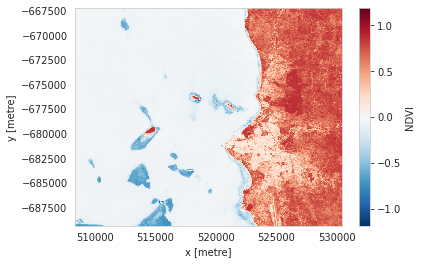

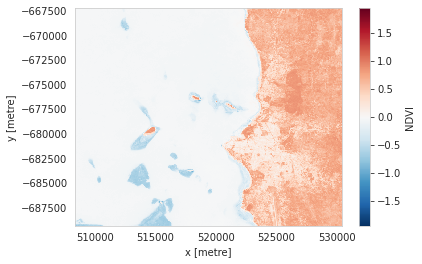

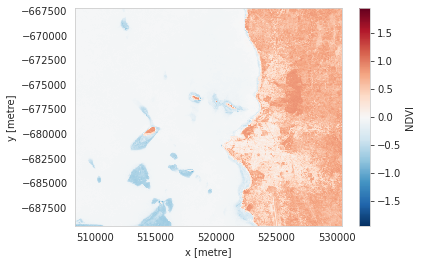

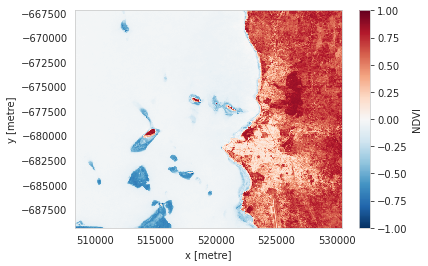

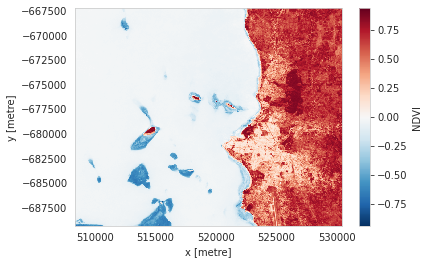

In [45]:
for images_year in images_years:
    datacollection[images_year]['NDVI'].plot(size=4)

In [25]:
closed_mangrove = {}
open_mangrove = {}
closed_mangrove = []
open_mangrove = []
for images_year in images_years:
    closed_mangrove[images_year] = datacollection[images_year].where(datacollection[images_year]['NDVI'] > 0.7).count(dim=['x','y']).NDVI.values.sum()
    open_mangrove[images_year] = datacollection[images_year].where(datacollection[images_year]['NDVI'] > 0.4).count(dim=['x','y']).NDVI.values.sum()

In [27]:
df = pd.DataFrame(open_mangrove, index=['All Mangrove Count']).append(pd.DataFrame(closed_mangrove,index=['Closed Mangrove Count']))
df

,2014,2015,2016,2017,2018
All Mangrove Count,159748,157835,155971,155478,155359
Closed Mangrove Count,79993,62273,56488,56608,58986


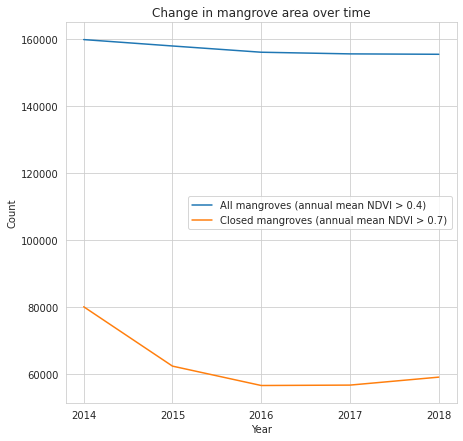

In [37]:
sns.set_style("whitegrid")

  

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(images_years, list(open_mangrove.values()), label='All mangroves (annual mean NDVI > {})'.format(0.4))
ax.plot(images_years, list(closed_mangrove.values()), label='Closed mangroves (annual mean NDVI > 0.7)')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Change in mangrove area over time')
plt.xlabel('Year')
plt.ylabel('Count')

plt.legend()

plt.show()

## Change in Mangroves
The following plot shows the change in pixel counts that correspond to a mangrove classification by means of the NDVI threshold.

## Mangroves Mapped
### All Mangroves for Chosen Year
The following image shows all the detected mangroves for the chosen year. Default selection is the last year in the selected range of years (YEARS[-1]).

In [ ]:
# Select the year to map here (ex: YEAR = 2013).
YEAR = YEARS[-1]

_all = mangroves.sel(year=YEAR).astype(int).where(mask).is_mangrove

print('All mangroves for the year {}.'.format(YEAR))
rgb(classifier.features.sel(year=YEAR).where(classifier.features.sel(year=YEAR).ndwi < 0),
    bands=['nir', 'nir', 'nir'],
    paint_on_mask=[(_all == 1, (0,255,0)),])

### Closed Mangroves for Chosen Year
The following image is the same as the first, but highlights closed mangroves (with NDVI > 0.7).

* Green - Closed Mangroves
* Tan - Other Mangroves

In [ ]:
_closed = closed_mangroves.sel(year=YEAR).astype(int).where(mask).is_closed_mangrove

print('Closed mangroves for the year {}.'.format(YEAR))

rgb(classifier.features.sel(year=YEAR).where(classifier.features.sel(year=YEAR).ndwi < 0),
    bands=['nir', 'nir', 'nir'],
    paint_on_mask=[(_all == 1, (248, 196, 113)),
                   (_closed == 1, (0,128,0)),])

### Change in Mangroves
The following image shows the change in mangroves between two selected years. Default selection is the oldest year and the year chosen above (YEARS[0], YEAR).

* Green - New Mangroves
* White - No Change
* Red - Loss of Mangroves

In [ ]:
# Select the year range here (ex: TIME = (2010, 2016)).
TIME = (YEARS[0], YEAR)

old = mangroves.sel(year=TIME[0] ).astype(int)
new = mangroves.sel(year=TIME[-1]).astype(int)
change = (new - old).rename(dict(is_mangrove = "mangrove_change"))

filtered_change = change.where(mask).mangrove_change

rgb(classifier.features.sel(year=TIME[-1]).where(classifier.features.sel(year=TIME[-1]).ndwi < 0),
    bands=['nir', 'nir', 'nir'],
    paint_on_mask=[(filtered_change == -1, (255,0,0)),
                   (filtered_change == 1 , (0,128,0)),
                   (filtered_change == 0, (255, 255, 255))])

#### Pixel Counts

In [ ]:
loss_count = mangroves.sel(year=TIME[0])['is_mangrove'].where(filtered_change == -1).sum()
gain_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 1).sum()
stable_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 0).sum()

counts = {
          'Loss of Mangroves': int(loss_count.item(0)),
          'New Mangroves': int(gain_count.item(0)),
          'No Change': int(stable_count.item(0)),
          'Delta Change': int(gain_count.item(0) - loss_count.item(0))
          }

df = pd.DataFrame(counts, index=['Pixel Count'])
print('Pixel Counts of Mangrove Changes Between the Years {} and {}:'.format(TIME[0], TIME[1]))
df

In [ ]:
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])